<a href="https://colab.research.google.com/github/nickwan/2021-nfl-qb-predict/blob/main/2021_nfl_predict_qb_tds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install subversion --quiet  
!svn export https://github.com/guga31bb/nflfastR-data/trunk/data "/content/drive/My Drive/nflfastR-data/data" --force --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd6

In [18]:
import os 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from sklearn.model_selection import GroupKFold
import itertools
import warnings

In [19]:
project_dir = 'drive/My Drive/nflfastR-data'

In [20]:
fns = [f"{project_dir}/data/{x}" for x in os.listdir(f"{project_dir}/data") if (".csv" in x) and ("play_by_play" in x)]
df = pd.DataFrame()
for fn in tqdm(fns):
  try:
    _df = pd.read_csv(fn, compression='gzip')
    df = df.append(_df, ignore_index=True)
  except:
    print('lol get rekt')
    continue

df.shape  

  0%|          | 0/23 [00:00<?, ?it/s]

lol get rekt


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37,179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types.Specif

(1047858, 372)

In [21]:
df.columns.values

array(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive',
       'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo',
       'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun',
       'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
       'extra_point_result', 'two_point_conv_result',
       'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
       'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score'

In [22]:
df['is_home'] = df['posteam_type'].replace(['home', 'away', None], [1,0,0])
cols = ['defteam']
for col in cols:
  df[f'{col}_code'] = df[col].astype('category').cat.codes

In [23]:
feats = ['season', 'yardline_100', 'game_seconds_remaining', 'down', 'ydstogo', 
         'defteam_code', 'score_differential', 'is_home']
target = 'pass_touchdown'

df_not_20 = df.loc[(df['season']!=2020) & (df['pass_attempt']==1), feats+[target, 'passer_player_id', 'passer_player_name', 'game_id']]
df_20 = df.loc[(df['season']==2020) & (df['pass_attempt']==1), feats+[target, 'passer_player_id', 'passer_player_name', 'game_id']]

In [24]:
folds = 3
kf = GroupKFold(3)

df_pred = pd.DataFrame()
model_data = df_not_20.dropna(subset=feats+[target])
for train_idx, test_idx in tqdm(kf.split(model_data, groups=model_data['game_id']), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = LogisticRegression()
  model.fit(train_data.loc[:, feats], train_data[target])
  test_data[f"{target}_pred"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data, ignore_index=True)

df_pred.shape  

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_l

(402509, 13)

In [25]:
df_pred.sample(5)

,season,yardline_100,game_seconds_remaining,down,ydstogo,defteam_code,score_differential,is_home,pass_touchdown,passer_player_id,passer_player_name,game_id,pass_touchdown_pred
132712,2019,73.0,1954.0,3.0,18,31,2.0,1,0.0,00-0034577,K.Allen,2019_13_WAS_CAR,0.001582
102429,2015,37.0,3028.0,1.0,10,23,-3.0,1,0.0,00-0028118,T.Taylor,2015_04_NYG_BUF,0.034759
387883,2017,80.0,2841.0,2.0,15,16,-16.0,1,0.0,00-0027948,B.Gabbert,2017_13_LA_ARI,0.001105
53993,2008,17.0,410.0,3.0,6,29,-11.0,0,0.0,00-0026143,M.Ryan,2008_02_ATL_TB,0.123394
347122,2011,64.0,167.0,2.0,10,11,-6.0,1,0.0,00-0027950,C.Ponder,2011_07_GB_MIN,0.004408


In [26]:
df_agg = df_pred.loc[:, ['passer_player_id', 'passer_player_name', 'season', 'pass_touchdown', 'pass_touchdown_pred']].groupby(['passer_player_id', 'passer_player_name', 'season'], as_index=False).sum()

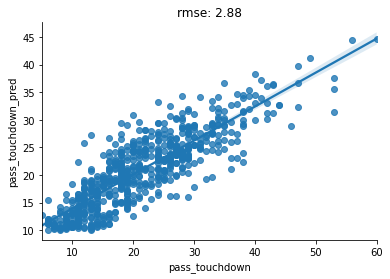

In [27]:
rmse = mean_squared_error(df_agg[target], df_agg[f"{target}_pred"])**0.5
sns.regplot(data=df_agg.loc[(df_agg[f'{target}_pred']>=10)], x=target, y=f'{target}_pred')
plt.title(f"rmse: {round(rmse, 2)}")
sns.despine()
plt.show()

In [28]:
df_not_20 = df_not_20.dropna(subset=feats+[target])
df_20 = df_20.dropna(subset=feats+[target])
model = LogisticRegression()
model.fit(df_not_20.loc[:, feats], df_not_20[target])
df_20[f"{target}_pred"] = pd.DataFrame(model.predict_proba(df_20.loc[:, feats]), index=df_20.index)[1]

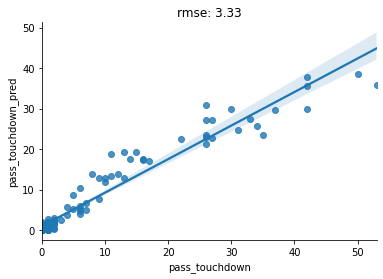

In [29]:
df_agg = df_20.loc[:, ['passer_player_id', 'passer_player_name', 'season', 'pass_touchdown', 'pass_touchdown_pred']].groupby(['passer_player_id', 'passer_player_name', 'season'], as_index=False).sum()
rmse = mean_squared_error(df_agg[target], df_agg[f"{target}_pred"])**0.5
sns.regplot(data=df_agg, x=target, y=f'{target}_pred')
plt.title(f"rmse: {round(rmse, 2)}")
sns.despine()
plt.show()

In [30]:
feats

['season',
 'yardline_100',
 'game_seconds_remaining',
 'down',
 'ydstogo',
 'defteam_code',
 'score_differential',
 'is_home']

count    402509.000000
mean         52.510679
std          23.496355
min           1.000000
25%          35.000000
50%          56.000000
75%          72.000000
max          99.000000
Name: yardline_100, dtype: float64

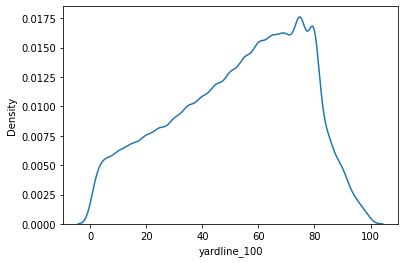

In [31]:
sns.kdeplot(df_not_20['yardline_100'])
df_not_20['yardline_100'].describe()

count    20170.000000
mean        51.167724
std         23.546092
min          1.000000
25%         33.000000
50%         55.000000
75%         71.000000
max         99.000000
Name: yardline_100, dtype: float64

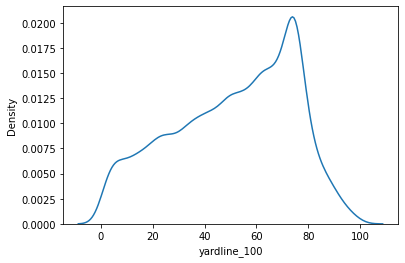

In [32]:
sns.kdeplot(df_20['yardline_100'])
df_20['yardline_100'].describe()

count    731.000000
mean      48.770178
std       23.419620
min        1.000000
25%       30.000000
50%       51.000000
75%       68.000000
max       99.000000
Name: yardline_100, dtype: float64

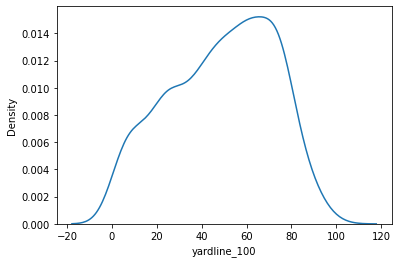

In [80]:
pid = "P.Mahomes"
sns.kdeplot(df_20.loc[df_20['passer_player_name']==pid,'yardline_100'])
df_20.loc[df_20['passer_player_name']==pid,'yardline_100'].describe()

count    438.000000
mean      49.289954
std       23.760156
min        1.000000
25%       30.250000
50%       52.500000
75%       68.000000
max       99.000000
Name: yardline_100, dtype: float64

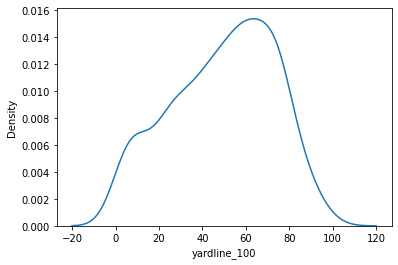

In [81]:
pid = "P.Mahomes"
one_player = df_20.loc[df_20['passer_player_name']==pid]
target = 'yardline_100'

est_passes = one_player.shape[0]
base_data = one_player.append(df_20.sample(int(round(est_passes*.75, 0))))
base_data = base_data.sample(est_passes)

sns.kdeplot(base_data.loc[base_data['passer_player_name']==pid,'yardline_100'])
base_data.loc[base_data['passer_player_name']==pid,'yardline_100'].describe()

In [38]:
model_data.head(5)

,season,yardline_100,game_seconds_remaining,down,ydstogo,defteam_code,score_differential,is_home,pass_touchdown,passer_player_id,passer_player_name,game_id
3,2000,63.0,3544.0,2.0,8,23,0.0,0,0.0,00-0013042,J.Plummer,2000_01_ARI_NYG
4,2000,63.0,3537.0,3.0,8,23,0.0,0,0.0,00-0013042,J.Plummer,2000_01_ARI_NYG
9,2000,68.0,3520.0,2.0,11,0,0.0,1,0.0,00-0003292,K.Collins,2000_01_ARI_NYG
10,2000,53.0,3520.0,1.0,10,0,0.0,1,0.0,00-0003292,K.Collins,2000_01_ARI_NYG
11,2000,42.0,3359.0,1.0,10,0,0.0,1,0.0,00-0003292,K.Collins,2000_01_ARI_NYG


In [291]:
schedule = pd.read_csv('https://github.com/nflverse/nfldata/blob/master/data/games.csv?raw=true')
schedule_21 = schedule.loc[schedule['season']==2021]

In [138]:
roster = pd.read_csv('https://github.com/nflverse/nflfastR-roster/blob/master/data/seasons/roster_2021.csv?raw=true')
qbs = roster.loc[(roster['depth_chart_position']=='QB') & (roster['status']=='Active')]
qbs['passer_player_name'] = qbs['first_name'].str[0].add('.').add(qbs['last_name'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['season',
 'yardline_100',
 'game_seconds_remaining',
 'down',
 'ydstogo',
 'defteam_code',
 'score_differential',
 'is_home']

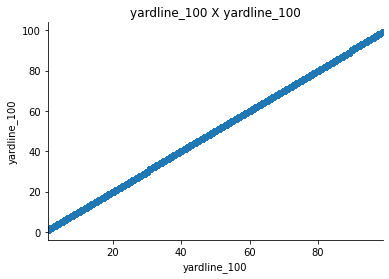

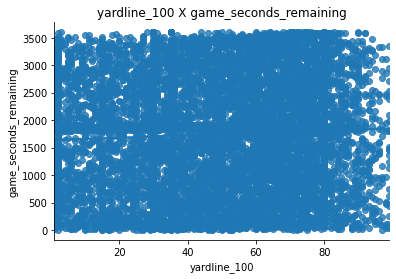

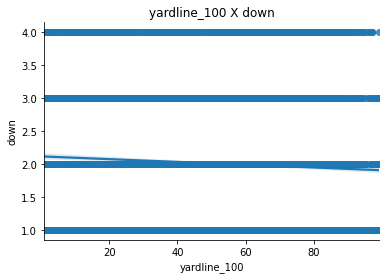

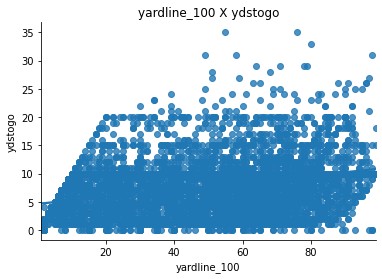

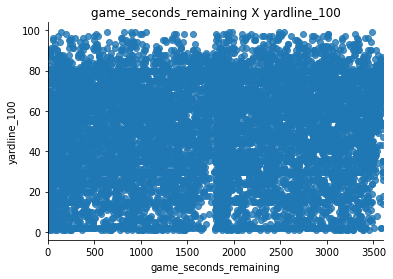

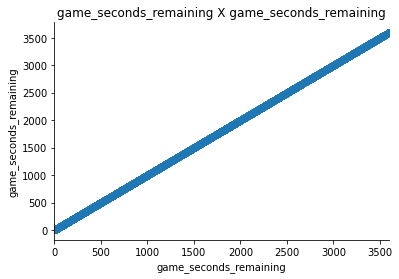

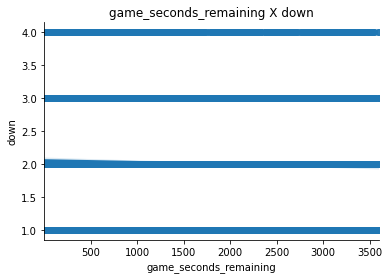

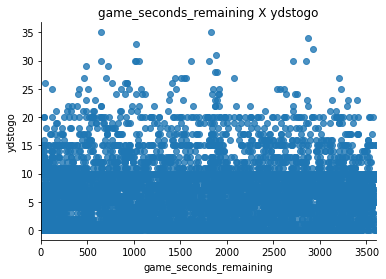

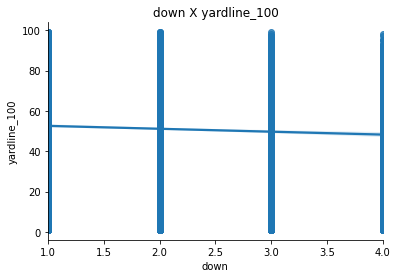

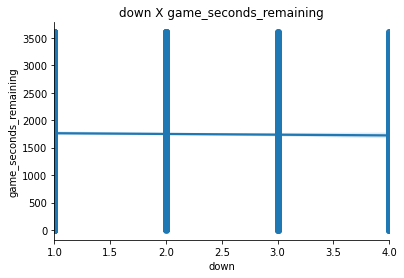

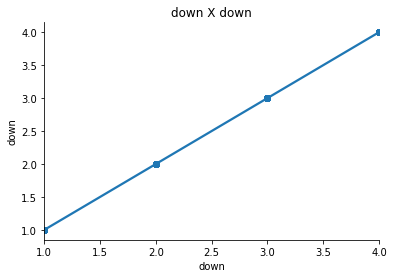

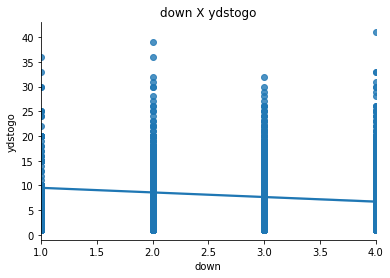

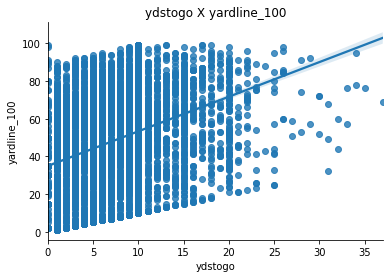

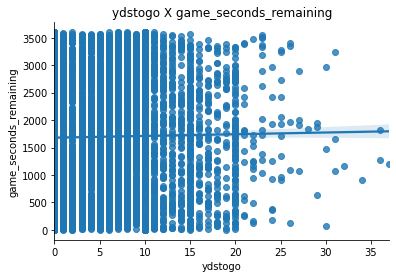

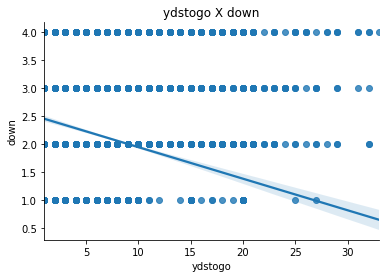

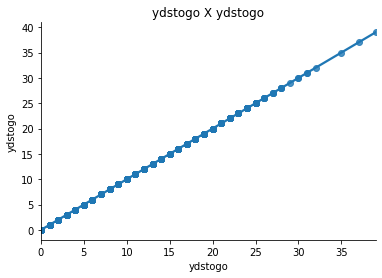

In [64]:
for x, y in itertools.product(['yardline_100', 'game_seconds_remaining', 'down', 'ydstogo'], ['yardline_100', 'game_seconds_remaining', 'down', 'ydstogo']):
  sns.regplot(data=df.sample(10000), x=x, y=y)
  sns.despine()
  plt.title(f"{x} X {y}")
  plt.show()


In [120]:
one_player = df.loc[df['passer_player_name']==pid]
est_passes = one_player.shape[0]
base_data = one_player.append(df.sample(int(round(est_passes*.75, 0))))
base_data.sample(est_passes).shape

(2078, 374)

In [141]:
qbs.head()

,season,team,position,depth_chart_position,jersey_number,status,full_name,first_name,last_name,birth_date,height,weight,college,high_school,gsis_id,espn_id,sportradar_id,yahoo_id,rotowire_id,pff_id,fantasy_data_id,sleeper_id,years_exp,headshot_url,passer_player_name
79,2021,ARI,QB,QB,12.0,Active,Colt McCoy,Colt,McCoy,1986-09-05,6-1,212.0,Texas,Jim Ned (TX),00-0027688,13199.0,3699dfd9-d437-43f7-b674-adbb31e7e64b,24060.0,6444.0,5609.0,11047.0,533,11.0,https://a.espncdn.com/combiner/i?img=/i/headsh...,C.McCoy
80,2021,ARI,QB,QB,9.0,Active,Cole McDonald,Cole,McDonald,1998-05-20,6-4,220.0,Hawaii,Sonora (CA),NaN,4038220.0,2d907c0c-cf4e-4564-b9eb-560d84f16144,32894.0,14493.0,NaN,21822.0,6954,1.0,https://a.espncdn.com/combiner/i?img=/i/headsh...,C.McDonald
81,2021,ARI,QB,QB,1.0,Active,Kyler Murray,Kyler,Murray,1997-08-07,5-10,207.0,Oklahoma,Allen (TX),00-0035228,3917315.0,dd5a6b6e-ffae-45a5-b8e6-718a9251f374,31833.0,13613.0,38334.0,20889.0,5849,2.0,https://a.espncdn.com/combiner/i?img=/i/headsh...,K.Murray
82,2021,ARI,QB,QB,15.0,Active,Chris Streveler,Chris,Streveler,1995-01-06,6-3,215.0,South Dakota,Marian Central Catholic (IL),00-0035752,3040206.0,23461354-f2d7-4e36-9046-fe9cde6dd413,32662.0,14587.0,46440.0,21866.0,6778,1.0,https://a.espncdn.com/combiner/i?img=/i/headsh...,C.Streveler
190,2021,ATL,QB,QB,2.0,Active,Matt Ryan,Matt,Ryan,1985-05-17,6-4,217.0,Boston College,Penn (PA),00-0026143,11237.0,7e648a0b-fdc8-4661-a587-5826f2cac11b,8780.0,5610.0,4317.0,732.0,24,13.0,https://a.espncdn.com/combiner/i?img=/i/headsh...,M.Ryan


In [145]:
qb_list = qbs.loc[:, ['gsis_id', 'passer_player_name', 'team']].drop_duplicates().dropna()

In [349]:
est_passes = df.loc[:, ['passer_player_id','season', 'game_seconds_remaining']].groupby(['passer_player_id','season'], as_index=False).count()
def n_ft_pt_passes(est_passes=est_passes):
  x = est_passes['game_seconds_remaining']
  pt_est_passes = x[x.between(20,250)].sample(1).values[0]
  ft_est_passes = x[x>450].sample(1).values[0]
  return pt_est_passes, ft_est_passes


def sim_data(pid, target, data_to_sample=df, pt_est_passes=pt_est_passes, 
             ft_est_passes=ft_est_passes):
  one_player = data_to_sample.loc[data_to_sample['passer_player_id']==pid]  
  if (one_player.empty) | (pt_est_passes>one_player.shape[0]):        
    _base_data_ft = data_to_sample.sample(ft_est_passes)
    _base_data_ft['is_ft'] = 1
    _base_data_pt = data_to_sample.sample(pt_est_passes)
    _base_data_pt['is_ft'] = 0    
  else:
    _est_passes = one_player.shape[0]
    _base_data = one_player.append(data_to_sample.sample(int(round(_est_passes*.5, 0))))
    _base_data_ft = _base_data.sample(_est_passes)
    _base_data_ft['is_ft'] = 1

    _base_data_pt = _base_data.sample(pt_est_passes)
    _base_data_pt['is_ft'] = 0

  base_data = _base_data_ft.append(_base_data_pt, ignore_index=True)
  output = base_data.loc[:, [target, 'is_ft']]
  return output

In [350]:
warnings.filterwarnings('ignore')
team_schedule = pd.DataFrame()
for team in tqdm(schedule_21['home_team'].unique()):
  _team_schedule = schedule_21.loc[(schedule_21['away_team']==team) | (schedule_21['home_team']==team)]
  _team_schedule['is_home'] = 0
  _team_schedule.loc[_team_schedule['home_team']==team, 'is_home'] = 1
  _team_schedule['defteam'] = _team_schedule['away_team']
  _team_schedule.loc[_team_schedule['is_home']==0, 'defteam'] = _team_schedule.loc[_team_schedule['is_home']==0, 'home_team']
  _team_schedule['team'] = team
  team_schedule = team_schedule.append(_team_schedule, ignore_index=True)
warnings.filterwarnings('default')  
team_schedule = team_schedule.loc[:, ['game_id', 'team', 'is_home', 'defteam']]
team_schedule = team_schedule.merge(df.loc[:, ['defteam','defteam_code']].drop_duplicates())

df_sim = pd.DataFrame()
for idx, row in tqdm(qb_list.iterrows(), total=qb_list.shape[0]):
  pid = row['gsis_id']
  pt_est_passes, ft_est_passes = n_ft_pt_passes()
  for idx, target in enumerate(['yardline_100', 'game_seconds_remaining', 'down', 'ydstogo', 'score_differential']):
    if idx==0:
      _df_sim = sim_data(pid, target, data_to_sample=df_20.dropna(subset=[target]), pt_est_passes=pt_est_passes, 
              ft_est_passes=ft_est_passes) 
    else:
      _df = sim_data(pid, target, data_to_sample=df_20.dropna(subset=[target]), 
                    pt_est_passes=pt_est_passes, ft_est_passes=ft_est_passes) 
      _df_sim[target] = _df[target]

  _df_sim['passer_player_id'] = pid
  _df_sim['passer_player_name'] = row['passer_player_name']
  _df_sim['team'] = row['team']
  _team_ids = pd.Series(team_schedule.loc[team_schedule['team']==row['team'], 'game_id'].sample(_df_sim.shape[0], replace=True).values)
  _df_sim['game_id'] = _team_ids
  df_sim = df_sim.append(_df_sim, ignore_index=True)
df_sim['season'] = 2021  
df_sim = df_sim.merge(team_schedule)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

In [355]:
warnings.filterwarnings('ignore')
feats = ['season', 'yardline_100', 'game_seconds_remaining', 'down', 'ydstogo', 
         'defteam_code', 'score_differential', 'is_home']
target = 'pass_touchdown'

model_data = df.loc[(df['pass_attempt']==1)].dropna(subset=feats+[target])
model = LogisticRegression()
model.fit(model_data.loc[:, feats], model_data[target])
df_sim[f"{target}_pred"] = pd.DataFrame(model.predict_proba(df_sim.loc[:, feats]), index=df_sim.index)[1]
warnings.filterwarnings('default')  

In [356]:
df_agg = df_sim.loc[:, ['team', 'passer_player_name', 'is_ft','pass_touchdown_pred']].groupby(['team', 'passer_player_name', 'is_ft'], as_index=False).sum()
df_agg.loc[df_agg['team']=='KC'].sort_values('pass_touchdown_pred', ascending=False)

,team,passer_player_name,is_ft,pass_touchdown_pred
109,KC,P.Mahomes,1,30.949911
105,KC,A.Gordon,1,26.367462
111,KC,S.Buechele,1,21.259779
110,KC,S.Buechele,0,8.423683
108,KC,P.Mahomes,0,7.489097
106,KC,C.Henne,0,2.080209
107,KC,C.Henne,1,2.036257
104,KC,A.Gordon,0,0.815245


In [358]:
df_agg.sort_values('pass_touchdown_pred', ascending=False).head(40)

,team,passer_player_name,is_ft,pass_touchdown_pred
21,BUF,J.Allen,1,36.834505
209,TB,T.Brady,1,36.148458
71,GB,A.Rodgers,1,31.762281
75,GB,J.Dolegala,1,31.618374
109,KC,P.Mahomes,1,30.949911
171,NYJ,M.White,1,30.510685
181,PIT,B.Roethlisberger,1,29.619741
199,SF,N.Sudfeld,1,29.042901
193,SEA,R.Wilson,1,28.791676
11,ATL,M.Ryan,1,28.786658


# places to improve  

this model + simulation is actually ultra ass. like it's so bad i'm kinda embarrassed that i made it at all and am proud of it in any way. it's really bad. like, no one should use this info for anything -- not even fantasy. like, you'll lose your fantasy league if you use these values AS IS in this notebook.

HOWEVER! There are lots of places for improvement. Here are some of the key areas you can improve this simple model into an advanced model with relative ease: 
* **better modeling data**. the data in this model is extremely simple! it would probably be improved if you have better data inputs -- we used a very small subset of features, but there are quite literally >300 features to choose from in the `nflfastR` data repo  
* **better model selection**. we used logistic regression and it was pretty decent, even though i know very well that logistic regression for predicting QB TDs is probably ass. you can have a much stronger, accurate prediction using more advanced modeling techniques. 
* **better simulation of 2021**. we literally used the maybe worst-but-acceptable simulation possible. you can improve the 2021 simulation input very easily imo by using `pymc3`, any `scipy` distribution sampling methods, fitting better distributions than simply empirical sampling, having model-driving simulations that take into account more information (e.g. more about the player + coach + team + opponent + formation + game state, perhaps?), or any other simulation techniques out there. there's a lot you can do to simulate and since that is one of the biggest, and perhaps most subjective, pieces of this model, diving into what makes a good simulation is pretty important to learn if this kind of stuff interests you!  

Overall, this notebook wasn't really meant for any strong accurate predictions. Rather, it was meant for (strangely) academic/educational purposes -- which is fairly rare on this stream. I do hope anyone who uses this as ML inspo or sports analytics inspo starts with some of the stuff here but improves upon the really lacking parts (as named above).  

-nw 2021-08-25